### AWSS3 - ResNetxxVx--CheXpert_augmented_images_multi_diagnose_out_of_memory_transfer_learning

In [4]:
# !pip install tensorflow
!pip install matplotlib
# !pip install s3fs
# !pip install pandas


  Using cached matplotlib-3.5.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached fonttools-4.28.3-py3-none-any.whl (884 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.3.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.1 MB)
  Using cached setuptools_scm-6.3.2-py3-none-any.whl (33 kB)
  Using cached tomli-1.2.2-py3-none-any.whl (12 kB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
#from keras.datasets import cifar10

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

#Sources/credits
#https://keras.io/examples/cifar10_resnet/


## Importing pretrained weights

In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception # TensorFlow ONLY
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import cv2

In [7]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

2.3.2
2.4.0


In [8]:
# Training parameters
batch_size = 2  # orig paper trained all networks with batch_size=128
epochs = 20
data_augmentation = True
num_classes = 2
input_dim = 299

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

In [9]:
n = 1

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2


In [10]:
depth

8

In [11]:
import os
# import cv2
import pickle
import pandas as pd
import s3fs
fs = s3fs.S3FileSystem()

TRAIN_FILE_LOCATION = 's3://chexrayproject-v1.0-small/train/'

train_info_loc = fs.open(TRAIN_FILE_LOCATION)

TRAIN_CSV_FILE_LOCATION = 's3://chexrayproject-v1.0-small/train.csv'
# train_file_name = "train.csv"
train_info = pd.read_csv(fs.open(TRAIN_CSV_FILE_LOCATION))

len(train_info)

4074

In [12]:
train_info['Path'].str.split('/').str[-3:]

0       [patient00001, study1, view1_frontal.jpg]
1       [patient00002, study2, view1_frontal.jpg]
2       [patient00002, study1, view1_frontal.jpg]
3       [patient00002, study1, view2_lateral.jpg]
4       [patient00003, study1, view1_frontal.jpg]
                          ...                    
4069    [patient00996, study3, view1_frontal.jpg]
4070    [patient00997, study1, view1_frontal.jpg]
4071    [patient00997, study2, view1_frontal.jpg]
4072    [patient00998, study1, view1_frontal.jpg]
4073    [patient00999, study1, view1_frontal.jpg]
Name: Path, Length: 4074, dtype: object

In [13]:
train_info.tail()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
4069,CheXpert-v1.0-small/train/patient00996/study3/...,Male,47,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,0.0
4070,CheXpert-v1.0-small/train/patient00997/study1/...,Female,63,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4071,CheXpert-v1.0-small/train/patient00997/study2/...,Female,64,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,NaN,1.0,NaN,NaN,NaN
4072,CheXpert-v1.0-small/train/patient00998/study1/...,Male,85,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,-1.0,-1.0,NaN,NaN,NaN,NaN,1.0
4073,CheXpert-v1.0-small/train/patient00999/study1/...,Female,44,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0


In [14]:
train_info.fillna(0, inplace=True)
train_info.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

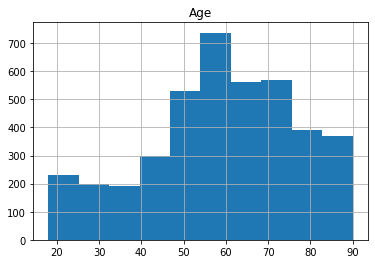

In [15]:
train_info.hist('Age')

In [16]:
col = list(train_info.columns)
diagnosis = col[5:]
diagnosis

['No Finding',
 'Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices']

### Create new dataframe with a column for complete path and diagnosis columns of interest

In [17]:
#NEED TO MODIFY THIS SO IT WORKS IN S3

#'D:\\Documents\\git\\med_imaging', "CheXpert-v1.0-small"
#train_df = pd.DataFrame(index=train_info.index)
data_df = train_info[col[5:]].copy()
data_df['xrays'] = [os.path.join('D:\\Documents\\git\\med_imaging',x) for x in train_info['Path'].values]


train_info['Path'].str.split('/').str[-3:]

0       [patient00001, study1, view1_frontal.jpg]
1       [patient00002, study2, view1_frontal.jpg]
2       [patient00002, study1, view1_frontal.jpg]
3       [patient00002, study1, view2_lateral.jpg]
4       [patient00003, study1, view1_frontal.jpg]
                          ...                    
4069    [patient00996, study3, view1_frontal.jpg]
4070    [patient00997, study1, view1_frontal.jpg]
4071    [patient00997, study2, view1_frontal.jpg]
4072    [patient00998, study1, view1_frontal.jpg]
4073    [patient00999, study1, view1_frontal.jpg]
Name: Path, Length: 4074, dtype: object

In [18]:
# ['s3://chexrayproject-v1.0-small/train/' + ('/').join(x.split('/')[-3:]) for x in train_info['Path'].values]

In [19]:
data_df = train_info[col[5:]].copy()
data_df['xrays'] = [TRAIN_FILE_LOCATION + ('/').join(x.split('/')[-3:]) for x in train_info['Path'].values]

In [20]:
data_df.head()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,xrays
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,s3://chexrayproject-v1.0-small/train/patient00...
1,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...
2,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...
3,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...


In [21]:
diag_cols = list(data_df.columns[:-1])
print(diag_cols, len(diag_cols))

['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'] 14


In [22]:
#For now replace the -1: negative with 0: no finding
data_df.replace(-1,0, inplace=True)

In [23]:
data_df.head(10)

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,xrays
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,s3://chexrayproject-v1.0-small/train/patient00...
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,s3://chexrayproject-v1.0-small/train/patient00...
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,s3://chexrayproject-v1.0-small/train/patient00...
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...


In [24]:
data_df.fillna(0, inplace=True)
data_df.head(10)

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,xrays
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,s3://chexrayproject-v1.0-small/train/patient00...
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,s3://chexrayproject-v1.0-small/train/patient00...
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,s3://chexrayproject-v1.0-small/train/patient00...
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...


In [25]:
diagnosis_counts = data_df[['No Finding',
 'Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices']].apply(pd.value_counts)

In [26]:
diagnosis_counts.head()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0.0,3591,3897,3545,2289,3894,3240,3818,3971,3546,3724,2591,3980,3903,2129
1.0,483,177,529,1785,180,834,256,103,528,350,1483,94,171,1945


# IGNORING CODE FOR T-SNE EMBEDDING

In [27]:
# ## importing the required packages
# from time import time
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import offsetbox
# from sklearn import manifold
# ## Loading and curating the data

# X = data_df.loc[:1000,col[5:]]

# n_samples, n_features = X.shape
# ## Function to Scale and visualize the embedding vectors
# def plot_embedding(X, title=None):
#     x_min, x_max = np.min(X, 0), np.max(X, 0)
#     X = (X - x_min) / (x_max - x_min)     
#     plt.figure(figsize=(12,12))
#     ax = plt.subplot(111)
#     for i in range(X.shape[0]):
#         plt.scatter(X[i, 0], X[i, 1], cmap=plt.cm.cool)
#         #plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
#         #         color=plt.cm.Set1(y[i] / 10.),
#         #         fontdict={'weight': 'bold', 'size': 9})

#     plt.xticks([]), plt.yticks([])
#     if title is not None:
#         plt.title(title)

#----------------------------------------------------------------------

# ## Computing t-SNE
# print("Computing t-SNE embedding")

# for j in range(20,50,5):
#     for i in range(10000,20000, 2000):
#         tsne = manifold.TSNE(perplexity=j, n_components=2, init='pca', n_iter=i, random_state=0)
#         t0 = time()
#         X_tsne = tsne.fit_transform(X)
#         title = "t-SNE embedding (time %.2fs), perp = %3d, iter= %5d " % (time() - t0, j, i)
#         plot_embedding(X_tsne, title)
#         plt.show()

In [28]:
# ## Function to Scale and visualize the embedding vectors
# def plot_embedding(X, title=None):
#     x_min, x_max = np.min(X, 0), np.max(X, 0)
#     X = (X - x_min) / (x_max - x_min)     
#     plt.figure(figsize=(16,16))
#     ax = plt.subplot(111)
#     for i in range(X.shape[0]):
#         plt.scatter(X[i, 0], X[i, 1], cmap=plt.cm.cool)
#         #plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
#         #         color=plt.cm.Set1(y[i] / 10.),
#         #         fontdict={'weight': 'bold', 'size': 9})

#     plt.xticks([]), plt.yticks([])
#     if title is not None:
#         plt.title(title)


In [29]:
# i,j = 45, 26000
# #tsne = manifold.TSNE(perplexity=i, n_components=2, init='pca', n_iter=j, random_state=0)
# t0 = time()
# #X_tsne = tsne.fit_transform(X)
# title = "t-SNE embedding (time %.2fs), perp = %3d, iter= %5d " % (time() - t0, i, j)
# plot_embedding(X_tsne, title)
# plt.show()

<AxesSubplot:>

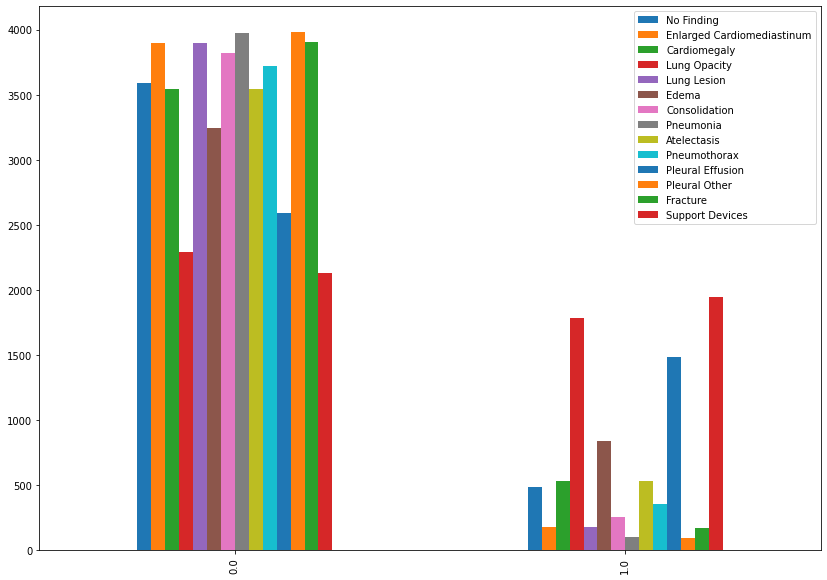

In [30]:
diagnosis_counts.plot(kind='bar', figsize=(14,10))

In [31]:
col

['Path',
 'Sex',
 'Age',
 'Frontal/Lateral',
 'AP/PA',
 'No Finding',
 'Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices']

# Check out some examples of x-rays

In [32]:
for i in range(3):
    print(data_df['xrays'].values[i])

s3://chexrayproject-v1.0-small/train/patient00001/study1/view1_frontal.jpg
s3://chexrayproject-v1.0-small/train/patient00002/study2/view1_frontal.jpg
s3://chexrayproject-v1.0-small/train/patient00002/study1/view1_frontal.jpg


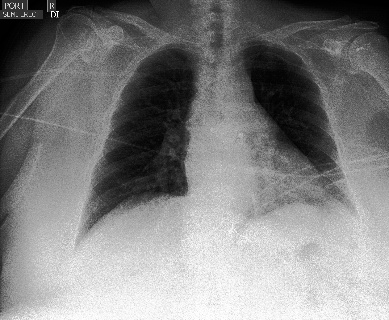

<class 'PIL.JpegImagePlugin.JpegImageFile'>


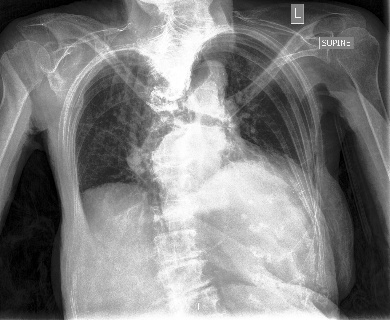

<class 'PIL.JpegImagePlugin.JpegImageFile'>


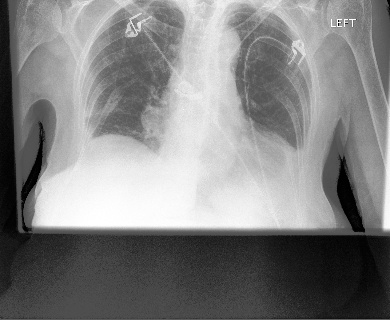

<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [34]:
# Loading image with help from SO: https://stackoverflow.com/questions/55480467/how-to-load-image-data-from-s3-bucket-to-sagemaker-notebook

from PIL import Image
import s3fs

fs = s3fs.S3FileSystem()


# open it directly
for i in range(3):
    with fs.open(data_df['xrays'].values[i]) as f:
        display(Image.open(f))
        print(type(Image.open(f)))



In [117]:
# Found this analytics vidhya suggestion (https://medium.com/analytics-vidhya/custom-keras-generator-fetching-images-from-s3-to-train-neural-network-4e98694de8ee)
import boto3
s3 = boto3.resource('s3')
import io
from PIL import Image

def fetch_input(path, s3):
    path = '/'.join(path.split('/')[-4:]) #This grabs the key for the bucket object of the form /train/patientXXXXX/studyX/viewXXXXXXX.jpg
    print(path)
    img_object = s3.Object('chexrayproject-v1.0-small', path)
#     io.BytesIO(object.get()['Body'].read())
    print(img_object)
    bytes_img_object = io.BytesIO(img_object.get()['Body'].read())
    pil_img = Image.open(io.BytesIO(bytes_img_object))
    img = load_img(pil_img)
    return(img)

In [115]:
data_df['xrays'].values[37]

's3://chexrayproject-v1.0-small/train/patient00012/study2/view2_lateral.jpg'

In [118]:
for i in range(3):
    s3_file = data_df['xrays'].values[i]
    test_image = fetch_input(s3_file, s3)
    print(np.array(test_image).shape)
    plt.figure(figsize=(16,16))
    plt.subplot(4,1,i+1)
    plt.imshow(test_image)
    plt.show()

train/patient00001/study1/view1_frontal.jpg
s3.Object(bucket_name='chexrayproject-v1.0-small', key='train/patient00001/study1/view1_frontal.jpg')


TypeError: a bytes-like object is required, not '_io.BytesIO'

In [57]:
# #NOTES:
# '''
# Try to load the s3 file, and then apply load_img to that object
# '''


# from tensorflow.keras.preprocessing import image
# for i in range(3):
#     s3_file = fs.open(data_df['xrays'].values[i])
#     test_image = image.load_img(s3_file, target_size = (512, 512) , color_mode = 'grayscale')
#     print(np.array(test_image).shape)
#     plt.figure(figsize=(16,16))
#     plt.subplot(4,1,i+1)
#     plt.imshow(test_image)
#     plt.show()

TypeError: expected str, bytes or os.PathLike object, not S3File

In [ ]:
# This code doesn't work because load_img from the keras package, doesn't know what to do with s3 files.

# from tensorflow.keras.preprocessing import image
# for i in range(3):
#     test_image = image.load_img(fs.open(data_df['xrays'].values[i]), target_size = (512, 512) , color_mode = 'grayscale')
#     print(np.array(test_image).shape)
#     plt.figure(figsize=(16,16))
#     plt.subplot(4,1,i+1)
#     plt.imshow(test_image)
#     plt.show()
    
    

# Trying to load data to local cluster (most recent attempt first)

In [84]:

import boto3 
from botocore.exceptions import ClientError # Not necessary

# Remember to enter the cirrect bucket region below
s3 = boto3.resource('s3', region_name='us-east-1') 
# Replace the place holder with your correct bucket name
b = s3.Bucket('chexrayproject-v1.0-small') 
print(b)
summaries = b.objects.all()
for file in summaries:
    if file.key[-3:] != 'jpg':
        pass
    else:
        uri = file.key
        with fs.open(uri) as f:
            display(Image.open(f))
   
#         key = obj.key    
#         print(key)    
#         if not os.path.exists(os.path.dirname(key)):           
#             os.makedirs(os.path.dirname(key))

# The following is basically for exception handling and not necessary to include     
    try:         
        bucket.download_file(key, key)     
    except ClientError as e:         
        if e.response['Error']['Code'] == "404":             
            print("No object with this key.")        
        else:             
            raise


s3.Bucket(name='chexrayproject-v1.0-small')


PermissionError: Forbidden

In [50]:
# for i in range(3):
#     cwd = !pwd
#     cwd = str(cwd)
#     print(cwd + data_df['xrays'].values[i])

['/root/latestchexpert']s3://chexrayproject-v1.0-small/train/patient00001/study1/view1_frontal.jpg
['/root/latestchexpert']s3://chexrayproject-v1.0-small/train/patient00002/study2/view1_frontal.jpg
['/root/latestchexpert']s3://chexrayproject-v1.0-small/train/patient00002/study1/view1_frontal.jpg


In [42]:
# for i in range(3):
#     print(data_df['xrays'].values[i]) 

s3://chexrayproject-v1.0-small/train/patient00001/study1/view1_frontal.jpg
s3://chexrayproject-v1.0-small/train/patient00002/study2/view1_frontal.jpg
s3://chexrayproject-v1.0-small/train/patient00002/study1/view1_frontal.jpg


In [41]:
# for i in range(3):
#     !aws s3 cp data_df['xrays'].values[i] ./images/data_df['xrays'].values[i]



usage: aws s3 cp <LocalPath> <S3Uri> or <S3Uri> <LocalPath> or <S3Uri> <S3Uri>
Error: Invalid argument type

usage: aws s3 cp <LocalPath> <S3Uri> or <S3Uri> <LocalPath> or <S3Uri> <S3Uri>
Error: Invalid argument type

usage: aws s3 cp <LocalPath> <S3Uri> or <S3Uri> <LocalPath> or <S3Uri> <S3Uri>
Error: Invalid argument type


### The data generator: train, validation and test

In [107]:
#Create test train split

from sklearn.model_selection import GroupShuffleSplit

# Initialize the GroupShuffleSplit.
gss = GroupShuffleSplit(n_splits=1, test_size=0.01)

# Get the indexers for the split.
idx1, idx2 = next(gss.split(data_df, groups=data_df.index))

# Get the split DataFrames.
df1, df2 = data_df.iloc[idx1], data_df.iloc[idx2]



#Just use a slice of the images for now:

train_temp_df = df1.sample(1000)
test_temp_df = df2.copy()

In [109]:
train_temp_df.head()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,xrays
1471,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...
2688,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,s3://chexrayproject-v1.0-small/train/patient00...
3845,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,s3://chexrayproject-v1.0-small/train/patient00...
3856,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,s3://chexrayproject-v1.0-small/train/patient00...
585,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,s3://chexrayproject-v1.0-small/train/patient00...


# Modifying Data Augmentation code to use flow_from_directory()


### (12/10/2021): Previous versions of the code relied on using groupsufflesplit to split a dataframe into a training and testing dataframe. Presently, we are more concerned with trying to just get the data to load. For now, I'm going to write code that will load the entirety of the training dataframe as present in s3. This will need to be modified later.

In [110]:
batch_size = 2
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

columns = diag_cols
seed = np.random.choice(range(9999))

#These functions generate more images
dg_args = dict(featurewise_center = False, 
               samplewise_center = False,
               rotation_range = 5, 
               rescale = 1/255.,
               width_shift_range = 0.05, 
               height_shift_range = 0.05, 
               shear_range = 0.01,
               zoom_range = [0.8, 1.2],  
               # anatomically it doesnt make sense, but many images are flipped
               horizontal_flip = True,  
               vertical_flip = False,
               fill_mode = 'nearest',
               data_format = 'channels_last')



image_gen = ImageDataGenerator(**dg_args)

test_image_gen = ImageDataGenerator(rescale=1./255.)

def gen_aug_images(data_path_directory, mode = "train", batch_size = batch_size):
    while True:
        #seed = 42
        seed = np.random.choice(range(9999))
        if mode == "train":
            # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
            train_img_label = image_gen.flow_from_directory(data_path_directory,
                                x_col='xrays',
                                y_col=columns,
                                #color_mode='grayscale',
                                batch_size=batch_size,
                                seed=seed,
                                shuffle=True,
                                validate_filenames=False,                        
                                class_mode="raw",
                                target_size=(input_dim,input_dim))
            
            for batch_x,batch_y in train_img_label:
                batch_labels = [batch_y[:,i] for i in range(14)]             
                #yield (batch_x, batch_labels)
                yield (batch_x, batch_labels)
            
        
        if mode == "validation":
            valid_img_label = image_gen.flow_from_directory(data_path_directory,
                                x_col='xrays',
                                y_col=columns,
                                #color_mode='grayscale',
                                batch_size=batch_size,
                                seed=seed,
                                shuffle=True,
                                validate_filenames=False,                        
                                class_mode="raw",
                                target_size=(input_dim,input_dim))

            for batch_x,batch_y in valid_img_label:
                batch_labels = [batch_y[:,i] for i in range(14)]             
                #yield (batch_x, batch_labels)
                yield (batch_x, batch_labels)
                

            
            
        if mode == "test":
            test_img = test_image_gen.flow_from_directory(data_path_directory,
                        x_col='xrays',
                        #color_mode='grayscale',
                        batch_size=1,
                        seed=seed,
                        shuffle=False,
                        class_mode= None,
                        target_size=(input_dim,input_dim))
            
            for batch_x in test_img:
                yield (batch_x)

#may not actually be masked... check this.      

masked_train_gen = gen_aug_images('s3://chexrayproject-v1.0-small', mode = "train", batch_size = batch_size)
# masked_val_gen = gen_aug_images(train_temp_df, mode = "validation", batch_size = batch_size)
# masked_test_gen = gen_aug_images(test_temp_df, mode = "test", batch_size = 1)

In [111]:
next(masked_train_gen)

TypeError: flow_from_directory() got an unexpected keyword argument 'x_col'

In [ ]:
#https://medium.com/@vijayabhaskar96/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24

batch_size = 2
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


columns = diag_cols
seed = np.random.choice(range(9999))

#These functions generate more images
dg_args = dict(featurewise_center = False, 
               samplewise_center = False,
               rotation_range = 5, 
               rescale = 1/255.,
               width_shift_range = 0.05, 
               height_shift_range = 0.05, 
               shear_range = 0.01,
               zoom_range = [0.8, 1.2],  
               # anatomically it doesnt make sense, but many images are flipped
               horizontal_flip = True,  
               vertical_flip = False,
               fill_mode = 'nearest',
               data_format = 'channels_last')



image_gen = ImageDataGenerator(**dg_args)

test_image_gen = ImageDataGenerator(rescale=1./255.)

def gen_aug_images(data_path_directory, mode = "train", batch_size = batch_size):
    while True:
        #seed = 42
        seed = np.random.choice(range(9999))
        if mode == "train":
            # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
            train_img_label = image_gen.flow_from_directory(data_path_directory,
                                x_col='xrays',
                                y_col=columns,
                                #color_mode='grayscale',
                                batch_size=batch_size,
                                seed=seed,
                                shuffle=True,
                                validate_filenames=False,                        
                                class_mode="raw",
                                target_size=(input_dim,input_dim))
            
            for batch_x,batch_y in train_img_label:
                batch_labels = [batch_y[:,i] for i in range(14)]             
                #yield (batch_x, batch_labels)
                yield (batch_x, batch_labels)
            
        
        if mode == "validation":
            valid_img_label = image_gen.flow_from_directory(data_path_directory,
                                x_col='xrays',
                                y_col=columns,
                                #color_mode='grayscale',
                                batch_size=batch_size,
                                seed=seed,
                                shuffle=True,
                                validate_filenames=False,                        
                                class_mode="raw",
                                target_size=(input_dim,input_dim))

            for batch_x,batch_y in valid_img_label:
                batch_labels = [batch_y[:,i] for i in range(14)]             
                #yield (batch_x, batch_labels)
                yield (batch_x, batch_labels)
                

            
            
        if mode == "test":
            test_img = test_image_gen.flow_from_directory(data_path_directory,
                        x_col='xrays',
                        #color_mode='grayscale',
                        batch_size=1,
                        seed=seed,
                        shuffle=False,
                        class_mode= None,
                        target_size=(input_dim,input_dim))
            
            for batch_x in test_img:
                yield (batch_x)

#may not actually be masked... check this.      

masked_train_gen = gen_aug_images(train_temp_df, mode = "train", batch_size = batch_size)
masked_val_gen = gen_aug_images(train_temp_df, mode = "validation", batch_size = batch_size)
masked_test_gen = gen_aug_images(test_temp_df, mode = "test", batch_size = 1)

# Code below only works on local machine with dataframe

In [112]:
#https://medium.com/@vijayabhaskar96/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24

batch_size = 2
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


columns = diag_cols
seed = np.random.choice(range(9999))

#These functions generate more images
dg_args = dict(featurewise_center = False, 
               samplewise_center = False,
               rotation_range = 5, 
               rescale = 1/255.,
               width_shift_range = 0.05, 
               height_shift_range = 0.05, 
               shear_range = 0.01,
               zoom_range = [0.8, 1.2],  
               # anatomically it doesnt make sense, but many images are flipped
               horizontal_flip = True,  
               vertical_flip = False,
               fill_mode = 'nearest',
               data_format = 'channels_last')



image_gen = ImageDataGenerator(**dg_args)

test_image_gen = ImageDataGenerator(rescale=1./255.)

def gen_aug_images(data_path_df, mode = "train", batch_size = batch_size):
    while True:
        #seed = 42
        seed = np.random.choice(range(9999))
        if mode == "train":
            # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
            train_img_label = image_gen.flow_from_dataframe(data_path_df,
                                x_col='xrays',
                                y_col=columns,
                                #color_mode='grayscale',
                                batch_size=batch_size,
                                seed=seed,
                                shuffle=True,
                                validate_filenames=False,                        
                                class_mode="raw",
                                target_size=(input_dim,input_dim))
            
            for batch_x,batch_y in train_img_label:
                batch_labels = [batch_y[:,i] for i in range(14)]             
                #yield (batch_x, batch_labels)
                yield (batch_x, batch_labels)
            
        
        if mode == "validation":
            valid_img_label = image_gen.flow_from_dataframe(data_path_df,
                                x_col='xrays',
                                y_col=columns,
                                #color_mode='grayscale',
                                batch_size=batch_size,
                                seed=seed,
                                shuffle=True,
                                validate_filenames=False,                        
                                class_mode="raw",
                                target_size=(input_dim,input_dim))

            for batch_x,batch_y in valid_img_label:
                batch_labels = [batch_y[:,i] for i in range(14)]             
                #yield (batch_x, batch_labels)
                yield (batch_x, batch_labels)
                

            
            
        if mode == "test":
            test_img = test_image_gen.flow_from_dataframe(data_path_df,
                        x_col='xrays',
                        #color_mode='grayscale',
                        batch_size=1,
                        seed=seed,
                        shuffle=False,
                        class_mode= None,
                        target_size=(input_dim,input_dim))
            
            for batch_x in test_img:
                yield (batch_x)

#may not actually be masked... check this.      

masked_train_gen = gen_aug_images(train_temp_df, mode = "train", batch_size = batch_size)
masked_val_gen = gen_aug_images(train_temp_df, mode = "validation", batch_size = batch_size)
masked_test_gen = gen_aug_images(test_temp_df, mode = "test", batch_size = 1)

In [113]:
gen_data = next(masked_train_gen)

Found 1000 non-validated image filenames.


FileNotFoundError: [Errno 2] No such file or directory: 's3://chexrayproject-v1.0-small/train/patient00252/study4/view1_frontal.jpg'

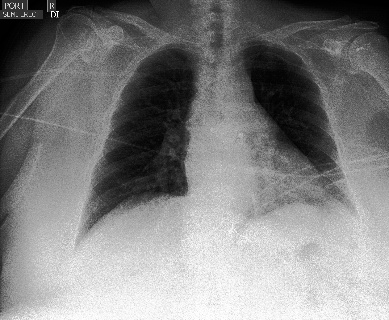

In [86]:
# open it directly
for i in range(1):
    with fs.open(data_df['xrays'].values[i]) as f:
        display(Image.open(f))
      

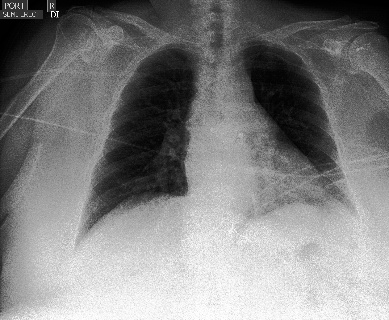

Size before reshaping is: (320, 389)


NoneType

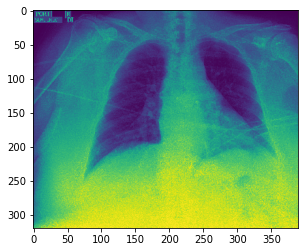

In [106]:
display(Image.open(fs.open(data_df['xrays'].values[0])))

image_object = Image.open(fs.open(data_df['xrays'].values[0]))

img_np_array = np.array(image_object)

print(f"Size before reshaping is: {np_array.shape}")


# np_array.reshape(input_dim, input_dim, 1) # this does not work, because dimensions mismatch

plt.imshow(img_np_array)

img_np_array_resized = img_np_array.resize(255, 255)

type(img_np_array_resized)

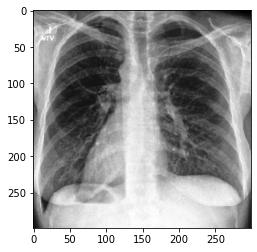

In [50]:
#gen_data[1][0]
plt.imshow((gen_data[0][0]).reshape(input_dim, input_dim,3))

In [51]:
gen_data[1]

[array([1., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 1.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([1., 0.])]

In [52]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [53]:
#num_classes = one_hot_y.shape[1]

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=num_classes):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(4):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    
    output1 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output2 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output3 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output4 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output5 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output6 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output7 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output8 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output9 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output10 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output11 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output12 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output13 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output14 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)

    
    #outputs = Dense(num_classes,activation='softmax', kernel_initializer='he_normal')(y)

    
    # Instantiate model.
    model = Model(inputs=inputs, 
                  outputs=[output1,output2,output3,output4,output5,output6,
                           output7,output8,output9,output10, output11,output12,output13,output14])
    
    return model



In [54]:
def resnet_v2(input_shape, depth, num_classes=num_classes):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    #outputs = Dense(num_classes,activation='softmax',kernel_initializer='he_normal')(y)
    
    output1 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output2 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output3 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output4 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output5 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output6 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output7 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output8 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output9 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output10 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output11 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output12 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output13 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
    output14 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)

    
    #outputs = Dense(num_classes,activation='softmax', kernel_initializer='he_normal')(y)

    
    # Instantiate model.
    model = Model(inputs=inputs, 
                  outputs=[output1,output2,output3,output4,output5,output6,
                           output7,output8,output9,output10, output11,output12,output13,output14])
    

    # Instantiate model.
    #model = Model(inputs=inputs, outputs=outputs)
    return model


In [55]:
version

1

In [56]:
# Model name, depth and version
model_type = 'Resnet%dv%d' % (depth, version)

# Load the CIFAR10 data.
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [57]:
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model



input_shape = (input_dim,input_dim,3)


#Choose version here
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

#model = resnet_v2(input_shape=input_shape, depth=depth)
model.compile(loss = ["binary_crossentropy","binary_crossentropy", "binary_crossentropy","binary_crossentropy", 
                      "binary_crossentropy","binary_crossentropy","binary_crossentropy", "binary_crossentropy",
                      "binary_crossentropy",      "binary_crossentropy", "binary_crossentropy","binary_crossentropy", 
                      "binary_crossentropy","binary_crossentropy"],
              optimizer=Adam(learning_rate=lr_schedule(0)), metrics=['accuracy'])

model.summary()
print(model_type)


Learning rate:  0.001
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 299, 299, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 299, 299, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 299, 299, 16) 0           batch_normalization[0][0]        
_________________________________________________________________

In [58]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'CheXpert_{}_{}_multiclass_model_epochs{}_bs{}.h5'.format(model_type, input_dim, epochs, batch_size)
#model_name = 'TB_ver1_%s_model.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [59]:
model_name

'CheXpert_Resnet8v1_299_multiclass_model_epochs20_bs2.h5'

In [60]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]
#callbacks = [lr_reducer, lr_scheduler]

In [61]:
#def generator_wrapper(generator):
#    for batch_x,batch_y in generator:
#        yield (batch_x,[batch_y[:,i] for i in range(14)])

In [ ]:
#batch_size = 4
#model.fit_generator(generator=generator_wrapper(gen_aug_images(train_temp_df, mode = "train", batch_size = batch_size)),steps_per_epoch=STEP_SIZE_TRAIN,
#                    validation_data=generator_wrapper(masked_val_gen), validation_steps=STEP_SIZE_VALID,
#                    epochs=1,verbose=2)

#model.fit_generator(masked_train_gen,steps_per_epoch=2,epochs=3,use_multiprocessing=True, workers=-1, 
#                              validation_data=masked_val_gen, validation_steps=2,
#                              callbacks=callbacks, verbose=0)

results = model.fit_generator(masked_train_gen, steps_per_epoch= 10000, epochs=epochs,
                              validation_data=masked_val_gen, validation_steps=100, verbose=1, callbacks=callbacks)

# Run training, with or without data augmentation.
#model.fit(x_train, y_train, batch_size=8, epochs=30,
#          validation_data=(x_val, y_val), shuffle=True, callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Learning rate:  0.001
Epoch 1/20
10000/10000 [==============================] - 3186s 319ms/step - loss: 4.9328 - dense_loss: 0.3064 - dense_1_loss: 0.1961 - dense_2_loss: 0.3650 - dense_3_loss: 0.6789 - dense_4_loss: 0.1716 - dense_5_loss: 0.5018 - dense_6_loss: 0.2476 - dense_7_loss: 0.1266 - dense_8_loss: 0.4300 - dense_9_loss: 0.2929 - dense_10_loss: 0.6244 - dense_11_loss: 0.0786 - dense_12_loss: 0.1653 - dense_13_loss: 0.6621 - dense_accuracy: 0.8978 - dense_1_accuracy: 0.9524 - dense_2_accuracy: 0.8800 - dense_3_accuracy: 0.5728 - dense_4_accuracy: 0.9593 - dense_5_accuracy: 0.7663 - dense_6_accuracy: 0.9324 - dense_7_accuracy: 0.9729 - dense_8_accuracy: 0.8469 - dense_9_accuracy: 0.9143 - dense_10_accuracy: 0.6420 - dense_11_accuracy: 0.9848 - dense_12_accuracy: 0.9614 - dense_13_accuracy: 0.6114 - val_loss: 4.9524 - val_dense_loss: 0.3742 - val_dense_1_loss: 0.1223 - val_dense_2_loss: 0.3469 - val_dens

In [40]:
#batch_size = 2
#STEP_SIZE_TRAIN=100//4
#STEP_SIZE_VALID=100//4
#STEP_SIZE_TEST=100//4
#model.fit_generator(generator=generator_wrapper(gen_aug_images(train_temp_df, mode = "train", batch_size = batch_size)),steps_per_epoch=STEP_SIZE_TRAIN,
#                    validation_data=generator_wrapper(masked_val_gen), validation_steps=STEP_SIZE_VALID,
#                    epochs=1,verbose=2)

#model.fit_generator(masked_train_gen,steps_per_epoch=2,epochs=3,use_multiprocessing=True, workers=-1, 
#                              validation_data=masked_val_gen, validation_steps=2,
#                              callbacks=callbacks, verbose=0)

results = model.fit_generator(masked_train_gen, steps_per_epoch= 20000, epochs=5,
                              validation_data=masked_val_gen, validation_steps=100,
                              callbacks=callbacks, verbose=1)

# Run training, with or without data augmentation.
#model.fit(x_train, y_train, batch_size=8, epochs=30,
#          validation_data=(x_val, y_val), shuffle=True, callbacks=callbacks)


Learning rate:  0.001
Epoch 1/5
20000/20000 [==============================] - 6018s 301ms/step - loss: 4.6387 - dense_loss: 0.2724 - dense_1_loss: 0.1922 - dense_2_loss: 0.3518 - dense_3_loss: 0.6523 - dense_4_loss: 0.1668 - dense_5_loss: 0.4656 - dense_6_loss: 0.2412 - dense_7_loss: 0.1244 - dense_8_loss: 0.4182 - dense_9_loss: 0.2831 - dense_10_loss: 0.5710 - dense_11_loss: 0.0828 - dense_12_loss: 0.1657 - dense_13_loss: 0.6056 - dense_accuracy: 0.8992 - dense_1_accuracy: 0.9524 - dense_2_accuracy: 0.8793 - dense_3_accuracy: 0.6177 - dense_4_accuracy: 0.9588 - dense_5_accuracy: 0.7715 - dense_6_accuracy: 0.9326 - dense_7_accuracy: 0.9728 - dense_8_accuracy: 0.8487 - dense_9_accuracy: 0.9118 - dense_10_accuracy: 0.7002 - dense_11_accuracy: 0.9830 - dense_12_accuracy: 0.9599 - dense_13_accuracy: 0.6767 - val_loss: 4.7365 - val_dense_loss: 0.3474 - val_dense_1_loss: 0.1735 - val_dense_2_loss: 0.3559 - val_dense_3_loss: 0.6918 - val_dense_4_loss: 0.1368 - val_dense_5_loss: 0.5040 - val_

In [38]:
from tensorflow.python.keras.models import load_model, save_model

In [38]:
#Save this way also
filepath = os.path.join(save_dir, model_name)
# load model
model.save(filepath = filepath)
#model = load_model('model.h5')

In [86]:
loaded_model = load_model(os.path.join(save_dir, 'CheXpert_ResNet20v1_224_multiclass_model_epochs5.h5'))

In [143]:
#for i in range(150):
#    test_data.append(next(masked_gen))

In [39]:
#masked_test_gen.reset()
pred=model.predict_generator(masked_test_gen,steps=len(test_temp_df), verbose=1)

Found 2235 validated image filenames.
2235/2235 [==============================] - 58s 26ms/step


In [40]:
pred_bool = []
pred_bool = [(pred[i] > 0.5) for i in range(len(pred))]

In [41]:
predictions = [item.astype(int) for item in pred_bool]
predictions[10]

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [42]:
columns = diag_cols
#columns should be the same order of y_col
results=pd.DataFrame(index = test_temp_df.index)
for i in range(len(columns)):
    results[columns[i]] = predictions[i]
#ordered_cols = ["Filenames"] + columns
#results=results[ordered_cols] #To get the same column order
#results.to_csv("results.csv",index=False)
results.tail()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
223178,0,0,0,0,0,0,0,0,0,0,0,0,0,1
223217,0,0,0,1,0,1,0,0,0,0,0,0,0,0
223245,0,0,0,0,0,0,0,0,0,0,0,0,0,1
223345,0,0,0,1,0,0,0,0,0,0,0,0,0,1
223391,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [43]:
results.describe()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
count,2235.000000,2235.0,2235.0,2235.000000,2235.0,2235.000000,2235.0,2235.0,2235.0,2235.000000,2235.000000,2235.0,2235.0,2235.000000
mean,0.005369,0.0,0.0,0.714541,0.0,0.280537,0.0,0.0,0.0,0.001342,0.215213,0.0,0.0,0.651007
std,0.073094,0.0,0.0,0.451734,0.0,0.449362,0.0,0.0,0.0,0.036621,0.411062,0.0,0.0,0.476759
min,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
25%,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
50%,0.000000,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000
75%,0.000000,0.0,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000
max,1.000000,0.0,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,1.000000


In [112]:
test_temp_df[columns].describe()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
count,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000
mean,0.097092,0.051902,0.120805,0.467562,0.036689,0.232662,0.066667,0.021477,0.151678,0.083669,0.377629,0.017450,0.041163,0.502013
std,0.296149,0.221878,0.325974,0.499058,0.188039,0.422623,0.249500,0.144999,0.358789,0.276953,0.484903,0.130969,0.198712,0.500108
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
#Let us now see how the overall correctness is:
correct={}
tot_corr = 0
for col in results.columns:
    #print(len(results[col]))
    correct[col] = (results[col] == test_temp_df[col])*1
    tot_corr = tot_corr + sum(correct[col])/len(test_temp_df)
    print('{} : {}'.format(col,sum(correct[col])/len(test_temp_df)))
print('\n\nOverall percent correct {}'.format(tot_corr/len(results.columns)))

No Finding : 0.9136465324384787
Enlarged Cardiomediastinum : 0.9404921700223714
Cardiomegaly : 0.8791946308724832
Lung Opacity : 0.6044742729306488
Lung Lesion : 0.9651006711409396
Edema : 0.7337807606263982
Consolidation : 0.9293064876957494
Pneumonia : 0.9794183445190157
Atelectasis : 0.8425055928411633
Pneumothorax : 0.9190156599552572
Pleural Effusion : 0.6724832214765101
Pleural Other : 0.9838926174496644
Fracture : 0.9570469798657718
Support Devices : 0.6939597315436241


Overall percent correct 0.8581655480984338


In [70]:
model.history.history.keys()

dict_keys(['loss', 'dense_loss', 'dense_1_loss', 'dense_2_loss', 'dense_3_loss', 'dense_4_loss', 'dense_5_loss', 'dense_6_loss', 'dense_7_loss', 'dense_8_loss', 'dense_9_loss', 'dense_10_loss', 'dense_11_loss', 'dense_12_loss', 'dense_13_loss', 'dense_accuracy', 'dense_1_accuracy', 'dense_2_accuracy', 'dense_3_accuracy', 'dense_4_accuracy', 'dense_5_accuracy', 'dense_6_accuracy', 'dense_7_accuracy', 'dense_8_accuracy', 'dense_9_accuracy', 'dense_10_accuracy', 'dense_11_accuracy', 'dense_12_accuracy', 'dense_13_accuracy', 'val_loss', 'val_dense_loss', 'val_dense_1_loss', 'val_dense_2_loss', 'val_dense_3_loss', 'val_dense_4_loss', 'val_dense_5_loss', 'val_dense_6_loss', 'val_dense_7_loss', 'val_dense_8_loss', 'val_dense_9_loss', 'val_dense_10_loss', 'val_dense_11_loss', 'val_dense_12_loss', 'val_dense_13_loss', 'val_dense_accuracy', 'val_dense_1_accuracy', 'val_dense_2_accuracy', 'val_dense_3_accuracy', 'val_dense_4_accuracy', 'val_dense_5_accuracy', 'val_dense_6_accuracy', 'val_dense_7_

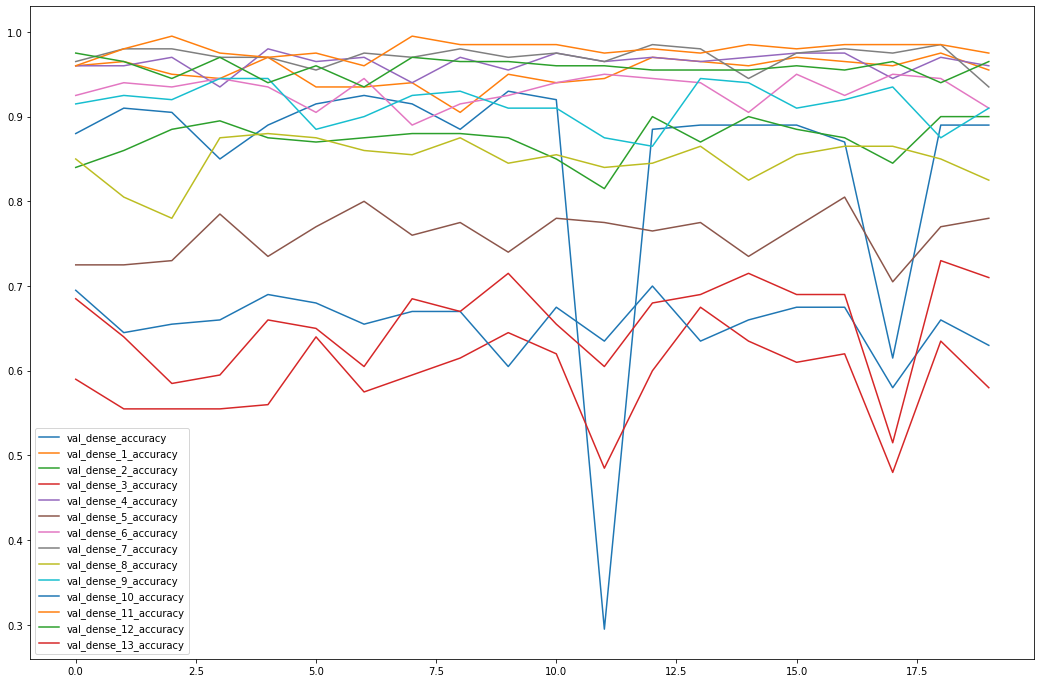

In [83]:
leg = []
plt.figure(figsize=(18,12))
for key in model.history.history.keys():
    if ('val' in key) & ('accuracy' in key):
        plt.plot(model.history.history[key])
        leg.append(key)
plt.legend(leg)
plt.show()

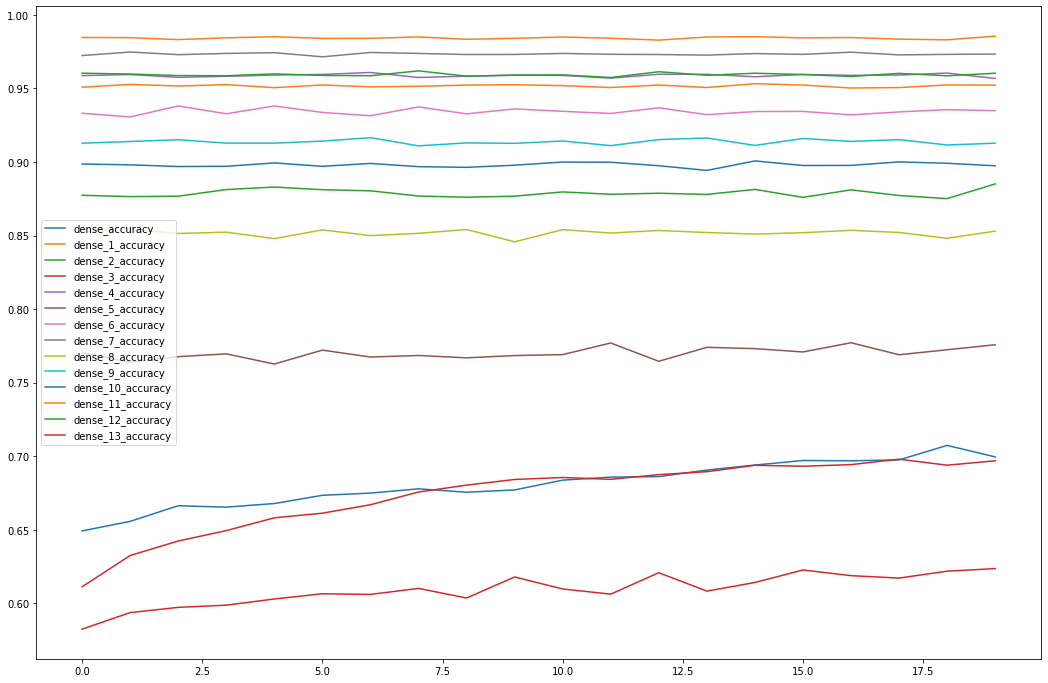

In [85]:
leg = []
plt.figure(figsize=(18,12))
for key in model.history.history.keys():
    if ('dense' in key) & ('accuracy' in key) & ('val' not in key):
        plt.plot(model.history.history[key])
        leg.append(key)
plt.legend(leg)
plt.show()

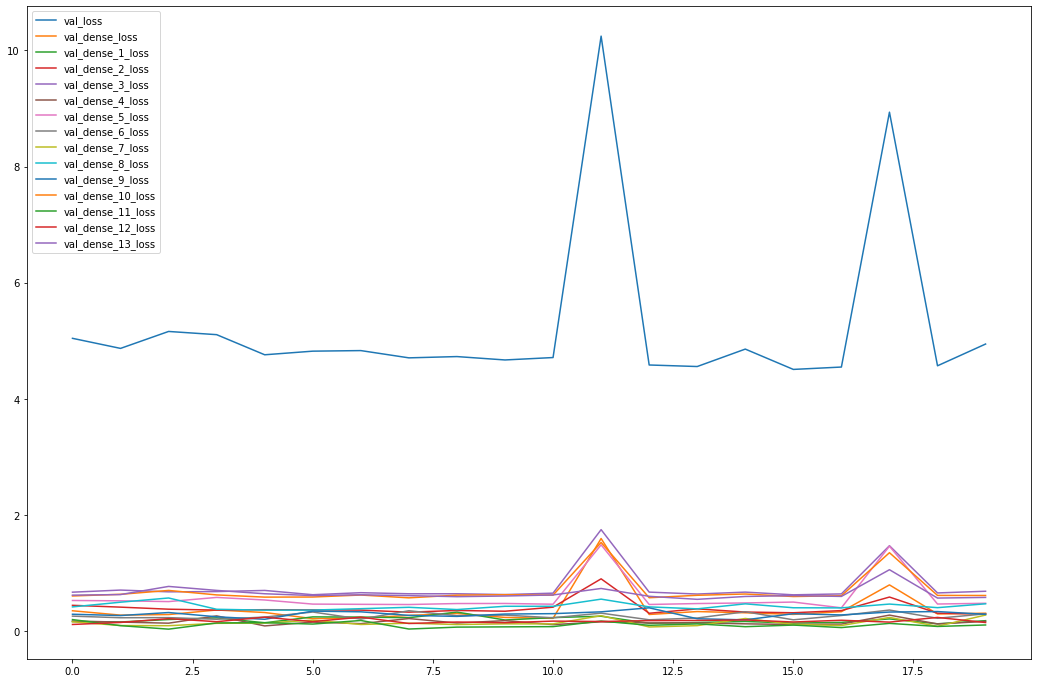

In [87]:
leg = []
plt.figure(figsize=(18,12))
for key in model.history.history.keys():
    if ('val' in key) & ('loss' in key):
        plt.plot(model.history.history[key])
        leg.append(key)
plt.legend(leg)
plt.show()

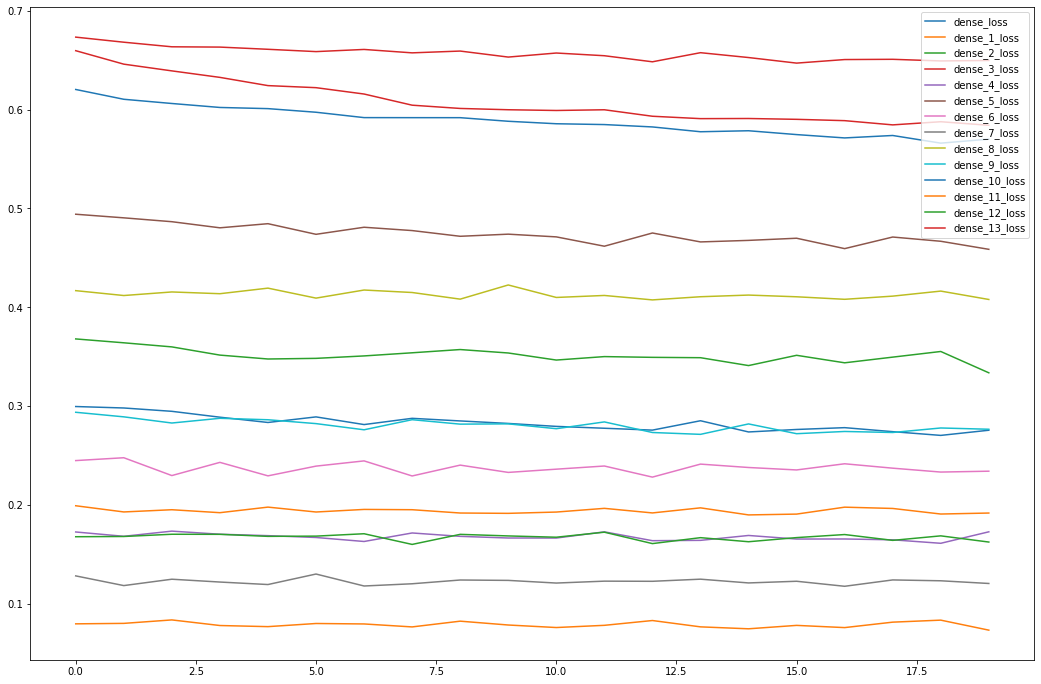

In [86]:
leg = []
plt.figure(figsize=(18,12))
for key in model.history.history.keys():
    if ('dense' in key) & ('loss' in key) & ('val' not in key):
        plt.plot(model.history.history[key])
        leg.append(key)
plt.legend(leg)
plt.show()

In [140]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

476/476 [==============================] - 9s 19ms/step
Test loss: 0.19136364156959437
Test accuracy: 0.9789915680885315


In [154]:
# Score trained model.
scores = loaded_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

476/476 [==============================] - 10s 20ms/step
Test loss: 0.19136364156959437
Test accuracy: 0.9789915680885315


### If using pretrained weights
#pyimagesearch

In [24]:
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model


# example of using the vgg16 model as a feature extraction model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16


from tensorflow.keras.models import Model
from pickle import dump


In [25]:
# example of loading the inception v3 model
from tensorflow.keras.applications.inception_v3 import InceptionV3
# load model
model = InceptionV3()
# summarize the model
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [133]:
# example of loading the resnet50 model
from tensorflow.keras.applications.resnet50 import ResNet50
# load model
model = ResNet50()
# summarize the model
model.summary()

A local file was found, but it seems to be incomplete or outdated because the md5 file hash does not match the original value of a7b3fe01876f51b976af0dea6bc144eb so we will re-download the data.
102858752/102853048 [==============================] - 20s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________

In [26]:
# example of loading the vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16
# load model
model = VGG16()
# summarize the model
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [76]:
#https://stackoverflow.com/questions/32871539/integer-factorization-in-python
from math import gcd

def factorization(n):

    factors = []

    def get_factor(n):
        x_fixed = 2
        cycle_size = 2
        x = 2
        factor = 1

        while factor == 1:
            for count in range(cycle_size):
                if factor > 1: break
                x = (x * x + 1) % n
                factor = gcd(x - x_fixed, n)

            cycle_size *= 2
            x_fixed = x

        return factor

    while n > 1:
        next = get_factor(n)
        factors.append(next)
        n //= next

    return factors

In [78]:
factorization(4096)

[8, 8, 8, 8]

In [122]:
# initialize the input image shape (224x224 pixels) along with
# the pre-processing function (this might need to be changed
# based on which model we use to classify our image)
inputShape = (224, 224)
preprocess = preprocess_input
# if we are using the InceptionV3 or Xception networks, then we
# need to set the input shape to (299x299) [rather than (224x224)]
# and use a different image processing function
#if args["model"] in ("inception", "xception"):
#	inputShape = (299, 299)
#	preprocess = preprocess_input

In [136]:
# load the input image using the Keras helper utility while ensuring
# the image is resized to `inputShape`, the required input dimensions
# for the ImageNet pre-trained network
print("[INFO] loading and pre-processing image...")
image = load_img(data_df['xrays'].values[1], target_size = (224, 224))

image = img_to_array(image)
# our input image is now represented as a NumPy array of shape
# (inputShape[0], inputShape[1], 3) however we need to expand the
# dimension by making the shape (1, inputShape[0], inputShape[1], 3)
# so we can pass it through thenetwork
image = np.expand_dims(image, axis=0)
# pre-process the image using the appropriate function based on the
# model that has been loaded (i.e., mean subtraction, scaling, etc.)
image = preprocess(image)

[INFO] loading and pre-processing image...


In [29]:
# load model without classifier layers
#model = ResNet50(include_top=False, input_shape=(input_dim,input_dim,3))
#If we don't want to train the weights:
#mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
    
#Also if don't want to train particular layers:
#mark some layers as not trainable
#model.get_layer('block1_conv1').trainable = False
#model.get_layer('block1_conv2').trainable = False
#model.get_layer('block2_conv1').trainable = False
#model.get_layer('block2_conv2').trainable = False

In [24]:
baseModel = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(299, 299, 3)))
# construct the head of the model that will be placed on top of the
# the base model

#mark loaded layers as not trainable
#for layer in baseModel.layers:
#    layer.trainable = False


headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
y = Dense(1024, activation="relu")(headModel)
#headModel = Dropout(0.5)(headModel)
output1 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output2 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output3 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output4 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output5 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output6 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output7 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output8 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output9 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output10 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output11 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output12 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output13 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output14 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
IV3model = Model(inputs=baseModel.input, outputs=[output1,output2,output3,output4,output5,output6, 
                                               output7,output8,output9,output10, output11,output12,output13,output14])
#model = resnet_v2(input_shape=input_shape, depth=depth)
IV3model.compile(loss = ["binary_crossentropy","binary_crossentropy", "binary_crossentropy","binary_crossentropy", 
                      "binary_crossentropy","binary_crossentropy","binary_crossentropy", "binary_crossentropy",
                      "binary_crossentropy",      "binary_crossentropy", "binary_crossentropy","binary_crossentropy", 
                      "binary_crossentropy","binary_crossentropy"],
              optimizer='adam', metrics=['accuracy'])

In [30]:
IV3results = IV3model.fit_generator(masked_train_gen, steps_per_epoch= 10000, epochs=10,
                              validation_data=masked_val_gen, validation_steps=100,
                              callbacks=callbacks, verbose=2)

Learning rate:  0.001
Epoch 1/10
Found 100000 non-validated image filenames.
10000/10000 - 3710s - loss: 5.0769 - dense_1_loss: 0.3309 - dense_2_loss: 0.2009 - dense_3_loss: 0.3763 - dense_4_loss: 0.7001 - dense_5_loss: 0.1673 - dense_6_loss: 0.5496 - dense_7_loss: 0.2454 - dense_8_loss: 0.1296 - dense_9_loss: 0.4281 - dense_10_loss: 0.3106 - dense_11_loss: 0.6758 - dense_12_loss: 0.0837 - dense_13_loss: 0.1772 - dense_14_loss: 0.7014 - dense_1_accuracy: 0.9007 - dense_2_accuracy: 0.9510 - dense_3_accuracy: 0.8780 - dense_4_accuracy: 0.5219 - dense_5_accuracy: 0.9620 - dense_6_accuracy: 0.7648 - dense_7_accuracy: 0.9354 - dense_8_accuracy: 0.9728 - dense_9_accuracy: 0.8526 - dense_10_accuracy: 0.9097 - dense_11_accuracy: 0.6068 - dense_12_accuracy: 0.9841 - dense_13_accuracy: 0.9589 - dense_14_accuracy: 0.5221 - val_loss: 5.1968 - val_dense_1_loss: 0.2601 - val_dense_2_loss: 0.2278 - val_dense_3_loss: 0.4397 - val_dense_4_loss: 0.6935 - val_dense_5_loss: 0.2378 - val_dense_6_loss: 0.56

In [40]:
#Save this way also
filepath = os.path.join(save_dir, model_name)
# load model
IV3model.save(filepath = filepath)
#model = load_model('model.h5')

In [31]:
preds = IV3model.predict_generator(masked_test_gen,steps=len(test_temp_df), verbose=1)

Found 2235 validated image filenames.
2235/2235 [==============================] - 163s 73ms/step


In [41]:
pred_bool = []
pred_bool = [(preds[i] > 0.6) for i in range(len(preds))]

In [42]:
predictions = [item.astype(int) for item in pred_bool]
len(predictions[10])

2235

In [43]:
columns = diag_cols
#columns should be the same order of y_col
results=pd.DataFrame(index = test_temp_df.index)
for i in range(len(columns)):
    results[columns[i]] = predictions[i]
#ordered_cols = ["Filenames"] + columns
#results=results[ordered_cols] #To get the same column order
#results.to_csv("results.csv",index=False)
results.tail()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
222902,0,0,0,0,0,0,0,0,0,0,0,0,0,1
222938,0,0,0,1,0,0,0,0,0,0,1,0,0,1
223011,0,0,0,1,0,0,0,0,0,0,1,0,0,1
223281,0,0,0,1,0,1,0,0,0,0,1,0,0,1
223391,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
results.describe()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
count,2235.0,2235.0,2235.0,2235.000000,2235.0,2235.000000,2235.0,2235.0,2235.0,2235.0,2235.000000,2235.0,2235.0,2235.000000
mean,0.0,0.0,0.0,0.302013,0.0,0.050559,0.0,0.0,0.0,0.0,0.320358,0.0,0.0,0.399105
std,0.0,0.0,0.0,0.459234,0.0,0.219145,0.0,0.0,0.0,0.0,0.466719,0.0,0.0,0.489824
min,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
50%,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
75%,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000
max,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000


In [38]:
test_temp_df[columns].describe()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
count,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000
mean,0.102013,0.044295,0.112304,0.468904,0.039374,0.235347,0.059955,0.025951,0.155705,0.091275,0.387025,0.014765,0.048322,0.519911
std,0.302734,0.205796,0.315811,0.499144,0.194526,0.424310,0.237457,0.159024,0.362656,0.288064,0.487178,0.120638,0.214494,0.499715
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(299, 299, 3)))
# construct the head of the model that will be placed on top of the
# the base model

#mark loaded layers as not trainable
for layer in baseModel.layers:
    layer.trainable = True


headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dropout(0.3)(headModel)
y = Dense(128, activation="relu")(headModel)


output1 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output2 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output3 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output4 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output5 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output6 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output7 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output8 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output9 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output10 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output11 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output12 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output13 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
output14 = Dense(1, activation = 'sigmoid',kernel_initializer='he_normal')(y)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=[output1,output2,output3,output4,output5,output6, 
                                               output7,output8,output9,output10, output11,output12,output13,output14])
#model = resnet_v2(input_shape=input_shape, depth=depth)
model.compile(loss = ["binary_crossentropy","binary_crossentropy", "binary_crossentropy","binary_crossentropy", 
                      "binary_crossentropy","binary_crossentropy","binary_crossentropy", "binary_crossentropy",
                      "binary_crossentropy",      "binary_crossentropy", "binary_crossentropy","binary_crossentropy", 
                      "binary_crossentropy","binary_crossentropy"],
              optimizer='adam', metrics=['accuracy'])

In [42]:
results = model.fit_generator(masked_train_gen, steps_per_epoch= 20000, epochs=3,
                              validation_data=masked_val_gen, validation_steps=100,
                              callbacks=callbacks, verbose=1)

Learning rate:  0.001
Epoch 1/3
20000/20000 [==============================] - 6144s 307ms/step - loss: 5.0522 - dense_20_loss: 0.3309 - dense_21_loss: 0.1997 - dense_22_loss: 0.3757 - dense_23_loss: 0.6944 - dense_24_loss: 0.1756 - dense_25_loss: 0.5450 - dense_26_loss: 0.2488 - dense_27_loss: 0.1282 - dense_28_loss: 0.4303 - dense_29_loss: 0.3028 - dense_30_loss: 0.6685 - dense_31_loss: 0.0833 - dense_32_loss: 0.1762 - dense_33_loss: 0.6926 - dense_20_accuracy: 0.8992 - dense_21_accuracy: 0.9514 - dense_22_accuracy: 0.8784 - dense_23_accuracy: 0.5224 - dense_24_accuracy: 0.9592 - dense_25_accuracy: 0.7653 - dense_26_accuracy: 0.9338 - dense_27_accuracy: 0.9730 - dense_28_accuracy: 0.8485 - dense_29_accuracy: 0.9123 - dense_30_accuracy: 0.6091 - dense_31_accuracy: 0.9846 - dense_32_accuracy: 0.9590 - dense_33_accuracy: 0.5286 - val_loss: 6.2834 - val_dense_20_loss: 0.5284 - val_dense_21_loss: 0.2456 - val_dense_22_loss: 0.4271 - val_dense_23_loss: 0.7783 - val_dense_24_loss: 0.2048 - 

In [55]:
results2 = model.fit_generator(masked_train_gen, steps_per_epoch= 5000, epochs=10,
                              validation_data=masked_val_gen, validation_steps=10,
                              callbacks=callbacks, verbose=2)

Learning rate:  0.001
Epoch 1/10
Found 100000 non-validated image filenames.
5000/5000 - 1515s - loss: 4.7759 - dense_20_loss: 0.2836 - dense_21_loss: 0.1906 - dense_22_loss: 0.3610 - dense_23_loss: 0.6639 - dense_24_loss: 0.1737 - dense_25_loss: 0.4983 - dense_26_loss: 0.2375 - dense_27_loss: 0.1317 - dense_28_loss: 0.4217 - dense_29_loss: 0.2934 - dense_30_loss: 0.6133 - dense_31_loss: 0.0775 - dense_32_loss: 0.1688 - dense_33_loss: 0.6610 - dense_20_accuracy: 0.9016 - dense_21_accuracy: 0.9531 - dense_22_accuracy: 0.8784 - dense_23_accuracy: 0.5980 - dense_24_accuracy: 0.9578 - dense_25_accuracy: 0.7649 - dense_26_accuracy: 0.9347 - dense_27_accuracy: 0.9710 - dense_28_accuracy: 0.8500 - dense_29_accuracy: 0.9131 - dense_30_accuracy: 0.6568 - dense_31_accuracy: 0.9848 - dense_32_accuracy: 0.9592 - dense_33_accuracy: 0.6128 - val_loss: 6.3080 - val_dense_20_loss: 0.3021 - val_dense_21_loss: 0.2064 - val_dense_22_loss: 0.2290 - val_dense_23_loss: 0.7276 - val_dense_24_loss: 0.1861 - v

In [56]:
preds = model.predict_generator(masked_test_gen,steps=len(test_temp_df), verbose=1)

Found 2235 validated image filenames.
2235/2235 [==============================] - 126s 56ms/step


In [57]:
pred_bool = []
pred_bool = [(preds[i] > 0.5) for i in range(len(preds))]

In [58]:
predictions = [item.astype(int) for item in pred_bool]
len(predictions[10])

2235

In [59]:
columns = diag_cols
#columns should be the same order of y_col
results=pd.DataFrame(index = test_temp_df.index)
for i in range(len(columns)):
    results[columns[i]] = predictions[i]
#ordered_cols = ["Filenames"] + columns
#results=results[ordered_cols] #To get the same column order
#results.to_csv("results.csv",index=False)
results.tail()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
222832,0,0,0,1,0,0,0,0,0,0,1,0,0,1
223026,0,0,0,0,0,0,0,0,0,0,0,0,0,0
223118,0,0,0,0,0,0,0,0,0,0,0,0,0,0
223343,0,0,0,0,0,0,0,0,0,0,0,0,0,1
223372,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [60]:
results.describe()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
count,2235.0,2235.0,2235.0,2235.000000,2235.0,2235.000000,2235.0,2235.0,2235.0,2235.0,2235.000000,2235.0,2235.0,2235.000000
mean,0.0,0.0,0.0,0.422819,0.0,0.027740,0.0,0.0,0.0,0.0,0.285906,0.0,0.0,0.657271
std,0.0,0.0,0.0,0.494118,0.0,0.164265,0.0,0.0,0.0,0.0,0.451946,0.0,0.0,0.474728
min,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
50%,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000
75%,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000
max,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000


In [41]:
test_temp_df[columns].describe()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
count,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000
mean,0.104698,0.051007,0.116331,0.471588,0.045190,0.219687,0.064430,0.027740,0.154362,0.092617,0.367338,0.012975,0.041611,0.506488
std,0.306232,0.220061,0.320693,0.499304,0.207767,0.414127,0.245571,0.164265,0.361377,0.289960,0.482187,0.113193,0.199743,0.500070
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [127]:
preds = model.predict_generator(masked_test_gen,steps=len(test_temp_df), verbose=1)

pred_bool = []
pred_bool = [(preds[i] > 0.6) for i in range(len(preds))]

predictions = [item.astype(int) for item in pred_bool]
len(predictions[10])

columns = diag_cols
#columns should be the same order of y_col
results=pd.DataFrame(index = test_temp_df.index)
for i in range(len(columns)):
    results[columns[i]] = predictions[i]
#ordered_cols = ["Filenames"] + columns
#results=results[ordered_cols] #To get the same column order
#results.to_csv("results.csv",index=False)
results.tail()

results.describe()

test_temp_df[columns].describe()MODELS = {
	"vgg16": VGG16,
	"vgg19": VGG19,
	"inception": InceptionV3,
	"xception": Xception, # TensorFlow ONLY
	"resnet": ResNet50
}
# esnure a valid model name was supplied via command line argument
if args["model"] not in MODELS.keys():
	raise AssertionError("The --model command line argument should "
		"be a key in the `MODELS` dictionary")

#https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

# To use pretrained weights as input to new network:
#VGG16
# example of tending the vgg16 model
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

# load model without classifier layers
model = VGG16(include_top=False, input_shape=(300, 300, 3))
#If we don't want to train the weights:
#mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
    
#Also if don't want to train particular layers:
#mark some layers as not trainable
#model.get_layer('block1_conv1').trainable = False
#model.get_layer('block1_conv2').trainable = False
#model.get_layer('block2_conv1').trainable = False
#model.get_layer('block2_conv2').trainable = False


# add new classifier layers
flat1 = Flatten()(model.outputs)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0   